# Test idea for scaling with only NMDA

In [2]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

In [3]:
from network import Protocol, BCPNNFast, NetworkManager
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success
from analysis_functions import calculate_recall_success_sequences, calculate_recall_time_quantities
from plotting_functions import plot_weight_matrix, plot_winning_pattern

In [43]:
# Patterns parameters
hypercolumns = 4
minicolumns = 20
n_patterns = 10

# Manager properties
dt = 0.001
T_recalling = 5.0
values_to_save = ['o']

tau_z_pre = 0.150

# Protocol
training_time = 0.400
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns, g_w_ampa=0.0, g_a=0.0, tau_z_pre=tau_z_pre, tau_m=0.005)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
protocol = Protocol()
patterns_indexes = [i for i in range(n_patterns)]
protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                         inter_sequence_interval=inter_sequence_interval, epochs=epochs)

# Train
manager.run_network_protocol(protocol=protocol, verbose=True)

('epochs', 0)
('epochs', 1)
('epochs', 2)


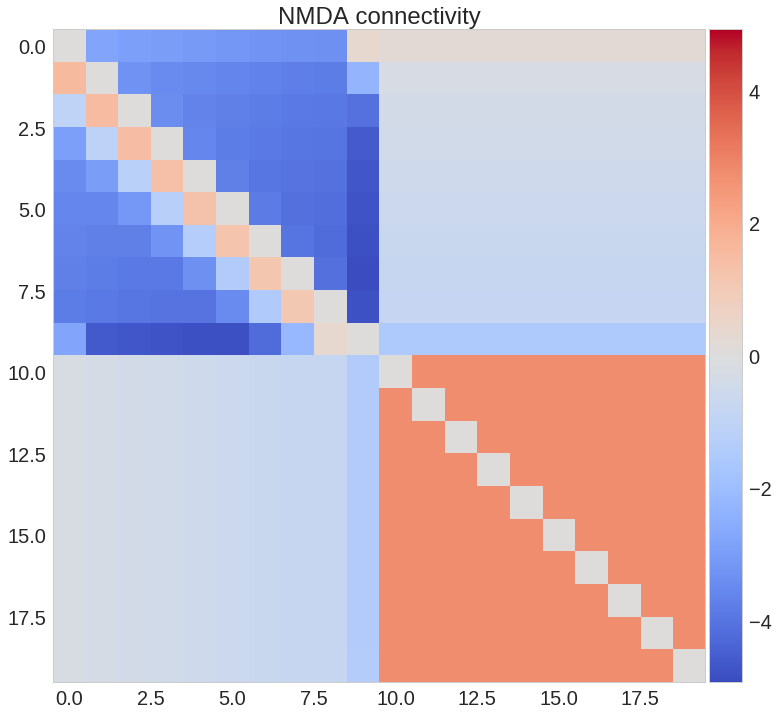

In [45]:
plot_weight_matrix(manager.nn)

In [52]:
n = 1
T_recall = 3.0
T_cue = 0.100
manager.nn.g_a = 0.0
manager.nn.g_w = 3.0
manager.nn.g_beta = 0.0
manager.nn.tau_m = 0.10
successes = calculate_recall_success(manager, T_recall=T_recall, I_cue=0, T_cue=T_cue,
                                     n=n, patterns_indexes=patterns_indexes)


angles = calculate_angle_from_history(manager)
winning_patterns = calculate_winning_pattern_from_distances(angles)
timings = calculate_patterns_timings(winning_patterns, manager.dt, remove=0.010)

In [53]:
timings

[(0, 0.72299999999999998, 0.0, 0.72199999999999998),
 (1, 0.77400000000000002, 0.72199999999999998, 1.4950000000000001),
 (2, 0.79100000000000004, 1.4950000000000001, 2.2850000000000001),
 (3, 0.81400000000000006, 2.2850000000000001, 3.0979999999999999)]

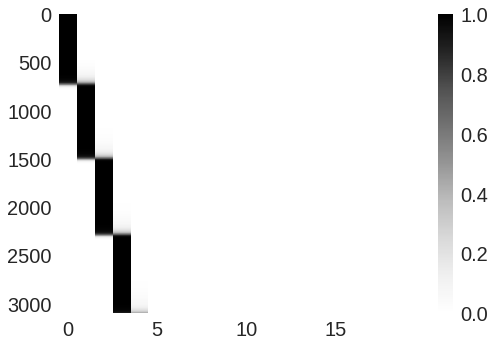

In [54]:
plt.imshow(angles, aspect='auto')
plt.grid()
plt.colorbar()

In [22]:
aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, [patterns_indexes])
total_sequence_time, mean, std, success, timings = aux

w_self = nn.w[4, minicolumns + 4] 
w_next = nn.w[4, 3] 
print(w_self)
print(w_next)

hypercolumn_factor = (1 - 1.0/hypercolumns)
ratio  = w_self / w_next
t = - nn.tau_z_pre * np.log(1 - ratio * hypercolumn_factor)

1.22706707568
1.38480142085


In [25]:
t

0.16385221097721006

In [24]:
mean

0.15785714285714286

## w_ampa ratio depending on the training time, epochs and w_next

#### Training time

In [41]:
# Patterns parameters
hypercolumns = 4
minicolumns = 20
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0


tau_z_pre = 0.150
epochs = 3

from_pattern = 3
to_pattern = 4
w_self_list = []
w_next_list = []
training_time_vector = np.arange(0.050, 1.050, 0.050)

for training_time in training_time_vector:
    print(training_time)

    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, g_w_ampa=0.0, tau_z_pre=tau_z_pre, g_a=0.0)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)
    w_self = nn.w[from_pattern, minicolumns + from_pattern] * (hypercolumns - 1)
    w_next = nn.w[to_pattern, from_pattern] * hypercolumns

    # Store
    w_self_list.append(w_self)
    w_next_list.append(w_next)

0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


Let's plot

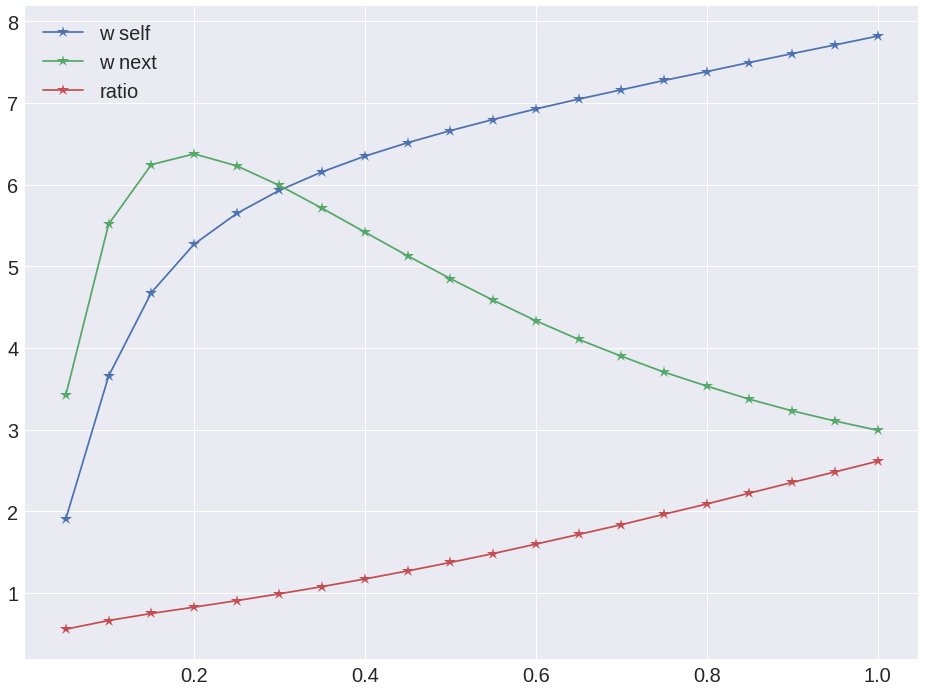

In [42]:
ratio = [x / y for (x, y) in zip(w_self_list, w_next_list)] 

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, w_self_list, '*-', markersize=13, label='w self')
ax.plot(training_time_vector, w_next_list, '*-', markersize=13, label='w next')
ax.plot(training_time_vector, ratio, '*-', markersize=13, label='ratio')

ax.legend();

#### tau_z

In [38]:
# Patterns parameters
hypercolumns = 4
minicolumns = 20
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

T_recall = 5.0

tau_z_pre = 0.150
epochs = 3

from_pattern = 3
to_pattern = 4
w_self_list = []
w_next_list = []
tau_z_pre_vector = np.arange(0.050, 0.550, 0.010)

for tau_z_pre in tau_z_pre_vector:
    print(tau_z_pre)

    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, g_w_ampa=0.0, tau_z_pre=tau_z_pre, g_a=0.0)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)
    w_self = nn.w[from_pattern, minicolumns + from_pattern] * (hypercolumns - 1)
    w_next = nn.w[to_pattern, from_pattern] * hypercolumns

    # Store
    w_self_list.append(w_self)
    w_next_list.append(w_next)
    
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, [patterns_indexes])
    total_sequence_time, mean, std, success, timings = aux

0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54


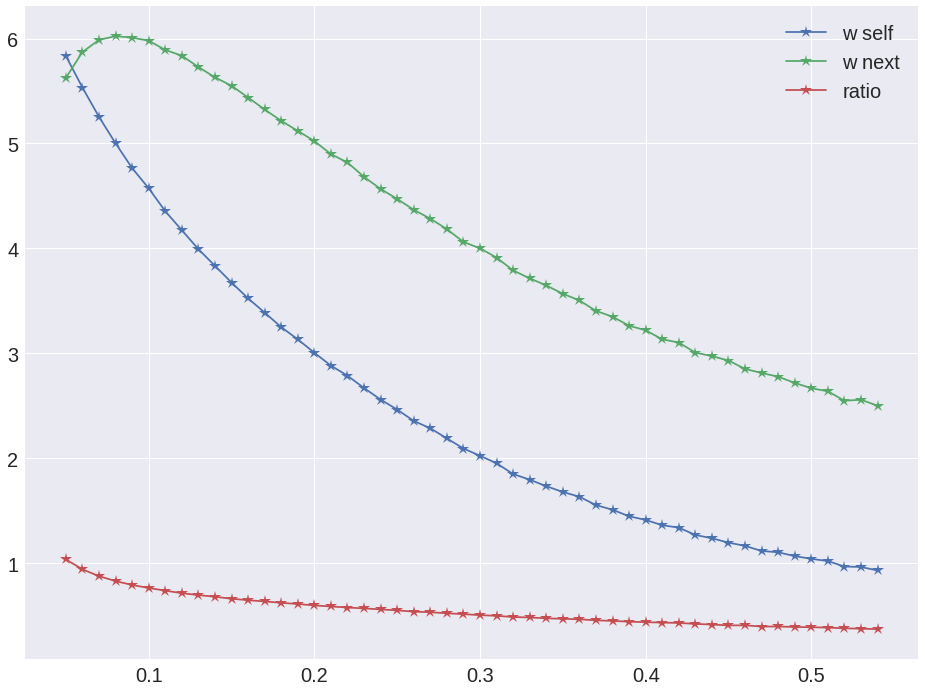

In [40]:
ratio = [x / y for (x, y) in zip(w_self_list, w_next_list)] 


fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_pre_vector, w_self_list, '*-', markersize=13, label='w self')
ax.plot(tau_z_pre_vector, w_next_list, '*-', markersize=13, label='w next')
ax.plot(tau_z_pre_vector, ratio, '*-', markersize=13, label='ratio')


ax.legend();

#### Epochs

In [43]:
# Patterns parameters
hypercolumns = 4
minicolumns = 20
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0


tau_z_pre = 0.150
epochs = 3

from_pattern = 3
to_pattern = 4
w_self_list = []
w_next_list = []
epochs_vector = np.arange(2, 12, 2)

for epochs in epochs_vector:
    print(epochs)

    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, g_w_ampa=0.0, tau_z_pre=tau_z_pre, g_a=0.0)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)
    w_self = nn.w[from_pattern, minicolumns + from_pattern] * (hypercolumns - 1)
    w_next = nn.w[to_pattern, from_pattern] * hypercolumns

    # Store
    w_self_list.append(w_self)
    w_next_list.append(w_next)

2
4
6
8
10


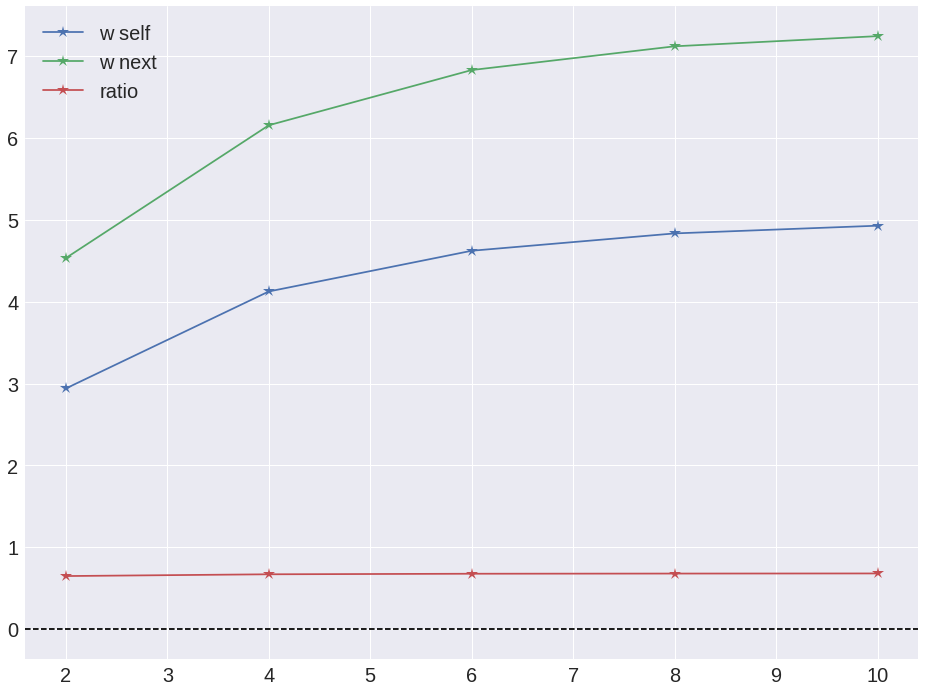

In [51]:
ratio = [x / y for (x, y) in zip(w_self_list, w_next_list)] 

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(epochs_vector, w_self_list, '*-', markersize=13, label='w self')
ax.plot(epochs_vector, w_next_list, '*-', markersize=13, label='w next')
ax.plot(epochs_vector, ratio, '*-', markersize=13, label='ratio')
        
        
ax.axhline(0, ls='--', color='black')

ax.legend();

## The theoretical curve

0.75
1.33333333333


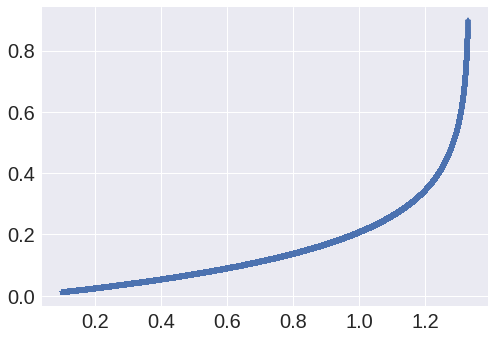

In [66]:
tau_z = 0.150
ratios = np.arange(0.1, 1.33, 0.00001)
H = 4
hypercolumn_factor = (1 - 1.0/H)
print(hypercolumn_factor)
print(1.0 /hypercolumn_factor)

t = - tau_z * np.log(1 - ratios * hypercolumn_factor)

plt.plot(ratios, t, '*-')

## Let's test this

In [58]:
# Patterns parameters
hypercolumns = 4
minicolumns = 20
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

T_recall = 10.0

tau_z_pre = 0.150
epochs = 3

from_pattern = 3
to_pattern = 4
prediction = []
calculated = []
training_time_vector = np.arange(0.050, 0.450, 0.050)

for training_time in training_time_vector:
    print(training_time)

    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, g_w_ampa=0.0, tau_z_pre=tau_z_pre, g_a=0.0,
                   tau_m=0.050, sigma=0, G=1.0)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)
    w_self = nn.w[from_pattern, minicolumns + from_pattern] 
    w_next = nn.w[to_pattern, from_pattern] 

    
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, [patterns_indexes])
    total_sequence_time, mean, std, success, timings = aux


    print(success)
    print(timings)
    hypercolumn_factor = (1 - 1.0/hypercolumns)
    ratio  = w_self / w_next
    t = - nn.tau_z_pre * np.log(1 - ratio * hypercolumn_factor)
    prediction.append(t)
    calculated.append(mean)

0.05
0.0
[(0, 0.156, 0.0, 0.155), (1, 0.17300000000000001, 0.155, 0.32700000000000001), (2, 0.129, 0.32700000000000001, 0.45500000000000002), (3, 0.114, 0.45500000000000002, 0.56800000000000006), (1, 0.013000000000000001, 0.56800000000000006, 0.57999999999999996), (0, 9.5190000000000001, 0.57999999999999996, 10.098000000000001)]
0.1
0.0
[(0, 0.154, 0.0, 0.153), (1, 0.115, 0.153, 0.26700000000000002), (2, 0.097000000000000003, 0.26700000000000002, 0.36299999999999999), (3, 0.108, 0.36299999999999999, 0.47000000000000003), (4, 0.129, 0.47000000000000003, 0.59799999999999998), (5, 0.122, 0.59799999999999998, 0.71899999999999997), (0, 9.3800000000000008, 0.71899999999999997, 10.098000000000001)]
0.15
0.0
[(0, 0.155, 0.0, 0.154), (1, 0.11900000000000001, 0.154, 0.27200000000000002), (2, 0.113, 0.27200000000000002, 0.38400000000000001), (3, 0.11600000000000001, 0.38400000000000001, 0.499), (4, 0.122, 0.499, 0.62), (5, 0.23000000000000001, 0.62, 0.84899999999999998), (0, 9.25, 0.8489999999999

/home/heberto/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in log


0.0
[(0, 10.099, 0.0, 10.098000000000001)]


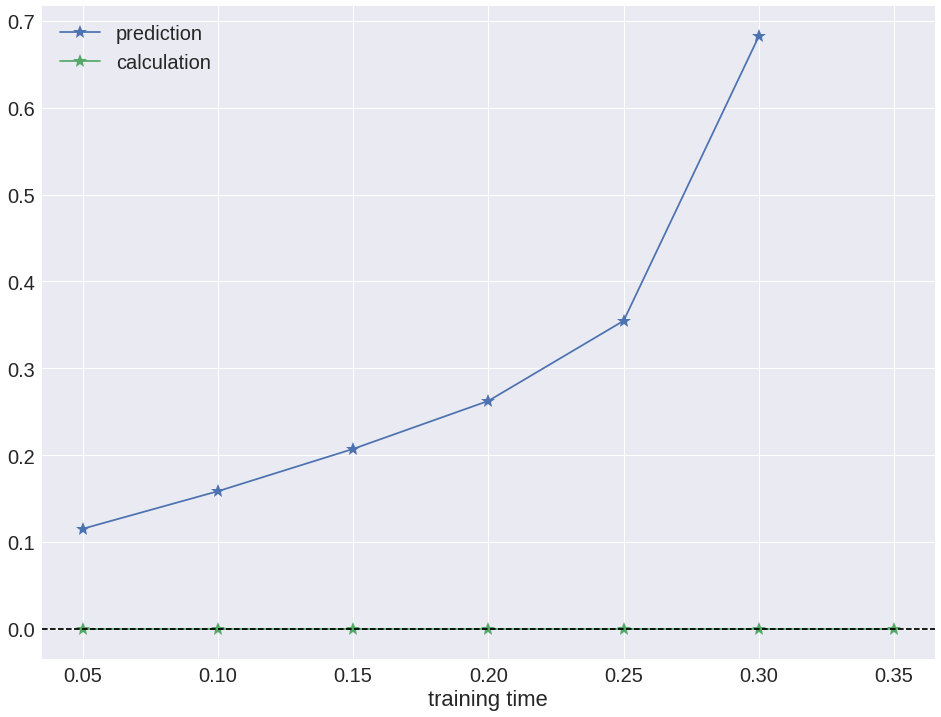

In [59]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, prediction, '*-', markersize=15, label='prediction')
ax.plot(training_time_vector, calculated, '*-', markersize=15, label='calculation')

ax.set_xlabel('training time')

ax.axhline(0, ls='--', color='black')
ax.legend();